In [1]:
import numpy as np
import glob
import datetime
from pmap import getmap
import pandas
import os
import lxml.etree as et
from netCDF4 import Dataset
import sys

In [2]:
%matplotlib notebook

## Read tide gauges data

In [3]:
OFILE='/mnt/pandora/Projects_Critech/EX_2015_CoastAlRisk/maps/data/s_b_data.txt'

In [4]:
obs=pandas.read_csv(OFILE,delimiter='\t')

In [5]:
obs

,ID,NAME,latobs,lonobs,latcalc,loncalc
0,1630,Almeira,36.8300,-2.4800,36.72506,-2.468386
1,1706,Valencia,39.4400,-0.3100,39.44040,-0.299000
2,819,Barcelona,41.3400,2.1600,41.27749,2.213909
3,1461,Palma de Mallorca,39.5600,2.6380,39.39457,2.614552
4,1741,Sete,43.3976,3.6991,43.31857,3.761195
5,1500,Corsica,42.9670,9.3500,43.09528,9.267036
6,1841,Carloforte,39.1480,8.3095,39.22599,8.231240
7,1848,Imperia,43.8783,8.0189,43.83057,8.149480
8,1846,Genova,44.4101,8.9255,44.32259,8.919400
9,1843,Civitavecchia,42.0940,11.7896,41.99920,11.677270


## Read HyFlux data

In [6]:
# define year
Y=2015

In [7]:
PATH='/mnt/ECMWF/processed/{}/FIX_MED_SEA/'.format(Y)  # ECMWF

### read bathymetry of first folder to define grid

In [8]:
folders=glob.glob(PATH+'calc_*')

In [9]:
filename=folders[0]+'/bathymetry.tif'
grid = getmap(filename)

gt=grid.GeoTr

width=grid.NCOLS
height=grid.NROWS

minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5]
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3]

lon=np.linspace(minx,maxx,width,endpoint=True)
lat=np.linspace(miny,maxy,height,endpoint=True)


### define start time of runs

In [10]:
odate=datetime.datetime.strptime(folders[0][-11:],'%Y%m%d.%H')
print odate

2015-01-01 00:00:00


We can check the restart date by parsing the locations.xml file ...

In [11]:
folders[0]+'/locations.xml'

'/mnt/ECMWF/processed/2015/FIX_MED_SEA/calc_20150101.00/locations.xml'

In [12]:
tree0=et.ElementTree(file=folders[0]+'/locations.xml')
for elem in list(tree0.getiterator()):
    if elem.tag == 'pubDate':
                 tinit=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                 break
tinit

datetime.datetime(2015, 1, 1, 0, 0)

In [13]:
#SELECT POINT from database above
point=14

In [14]:
plat,plon=obs['latcalc'][point],obs['loncalc'][point]

In [15]:
i=np.abs(lat-plat).argmin()
j=np.abs(lon-plon).argmin()


In [16]:
print i,j

216 292


In [17]:
obs['ID'][point]

1866

### specify dates 

In [18]:
t0='20150101.00'

In [19]:
t1='20151231.12'

In [20]:
tstart=datetime.datetime.strptime(t0,'%Y%m%d.%H')
tend=datetime.datetime.strptime(t1,'%Y%m%d.%H')


In [21]:
dt=(tend-tstart).total_seconds()
ndt=dt/(3600*12)
ndt=np.int(ndt)+1


## read from netCDF files

In [22]:
combined=[] # store time and height
tw=[]

In [23]:
for it in range(ndt):
    idate=tstart+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    
    # track completion
    sys.stdout.write('\r')
    sys.stdout.write(dstamp)
    sys.stdout.flush() 

    try:
        tree0=et.ElementTree(file=PATH+'calc_{}/locations.xml'.format(dstamp))
        for elem in list(tree0.getiterator()):
            if elem.tag == 'pubDate':
                tn=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                break
        if tn != tinit :
            sys.stdout.write( '  > restart date : {}'.format(tn)) # new restart day
            tinit=tn
        
    except:
        sys.stdout.write('  > problem with locations.xml file')
        pass


    try:

        filename=PATH+'calc_{}/NETCDF_H.nc'.format(dstamp)
        d =  Dataset(filename)
        ha=d.variables['HA'][:19,i,j] # the prior 6 hours + 12 hours forecasting
        t=d.variables['TIME'][:19]
        
        tp=[]
        for ts in t:
            if t[0] == 0 :
                tp.append(idate+datetime.timedelta(seconds=ts))
                tinit=idate
            else:
                tp.append(tinit+datetime.timedelta(seconds=ts))
                       
        iw1=np.argwhere(np.array(tp)==idate).flatten()[0]
        iw2=np.argwhere(np.array(tp)==idate+datetime.timedelta(hours=12)).flatten()[0]
        tw.append(tp[iw1:iw2+1])
        combined.append(ha[iw1:iw2+1])
    
    except:
        sys.stdout.write('  > problem with netcdf file, skiping'.format(dstamp))
        sys.stdout.write('\n')





20150422.00  > problem with locations.xml file  > problem with netcdf file, skiping
20150422.12  > problem with locations.xml file  > problem with netcdf file, skiping
20150424.00  > problem with netcdf file, skiping
20150425.12  > problem with netcdf file, skiping
20150426.12  > problem with netcdf file, skiping
20150427.00  > problem with locations.xml file  > problem with netcdf file, skiping
20150427.12  > problem with netcdf file, skiping
20150625.12  > problem with locations.xml file  > problem with netcdf file, skiping
20150626.00  > problem with locations.xml file  > problem with netcdf file, skiping
20150626.12  > problem with locations.xml file  > problem with netcdf file, skiping
20150627.00  > problem with netcdf file, skiping
20150707.12  > problem with locations.xml file  > problem with netcdf file, skiping
20150708.00  > problem with netcdf file, skiping
20151231.12

In [24]:
htcw=np.array(tw).flatten()
hcw=np.array(combined).flatten()

In [25]:
res=pandas.DataFrame(hcw,index=[htcw],columns=[obs['NAME'][point].strip()+'  netCDF'])

In [26]:
res[:2]

,S. Benedetto del Tronto netCDF
2015-01-01 00:00:00,0.00000
2015-01-01 01:00:00,-0.00723


<IPython.core.display.Javascript object>


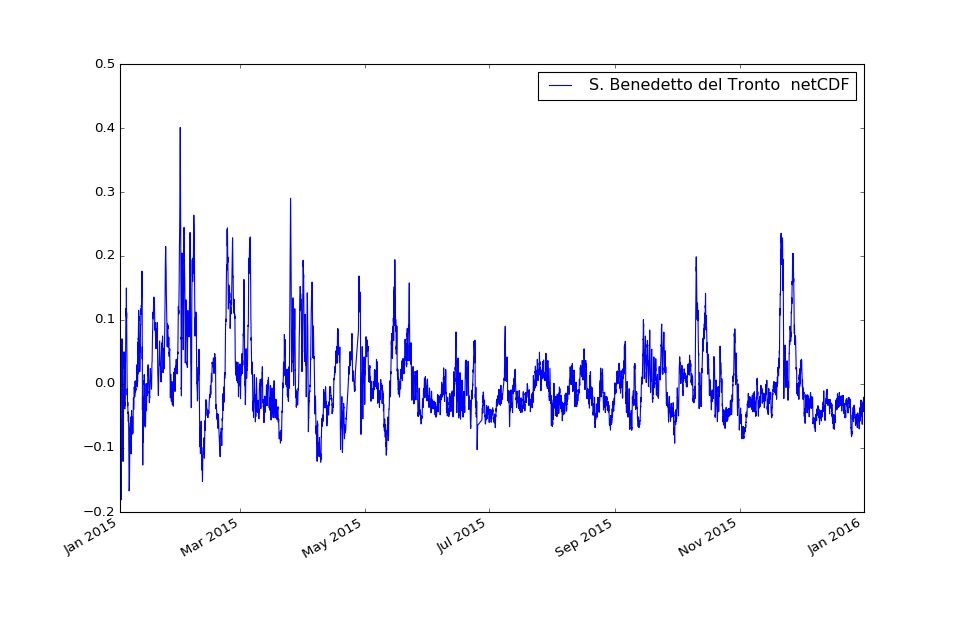

In [27]:
ax = res.plot(figsize=(12,8))


### Reading from tif files

In [28]:
combined=[] # store time and height
tw=[]

In [29]:
for it in range(ndt):
    idate=tstart+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    
    # track completion
    sys.stdout.write('\r')
    sys.stdout.write(dstamp)
    sys.stdout.flush() 

    try:
        tree0=et.ElementTree(file=PATH+'calc_{}/locations.xml'.format(dstamp))
        for elem in list(tree0.getiterator()):
            if elem.tag == 'pubDate':
                tn=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                break
        if tn != tinit :
            sys.stdout.write( '  > restart date : {}'.format(tn)) # new restart day
            tinit=tn
        
    except:
        sys.stdout.write('  > problem with locations.xml file')
        pass


    try:
        hfiles=glob.glob(PATH+'calc_{}/TIF_H*.tif'.format(dstamp))

        t=[np.int(l.split('_')[-1].split('.')[0]) for l in hfiles]
        
        # choose the files from the first 12 hours
        tp=[]
        for ts in t:
            if t[0] == 0 :
                tp.append(idate+datetime.timedelta(seconds=ts))
                tinit=idate
            else:
                tp.append(tinit+datetime.timedelta(seconds=ts))
                       
        iw1=np.argwhere(np.array(tp)==idate).flatten()[0]
        iw2=np.argwhere(np.array(tp)==idate+datetime.timedelta(hours=12)).flatten()[0]
        tw.append(tp[iw1:iw2+1])
                
        for ifile in hfiles[iw1:iw2+1]:  
            dat=getmap(ifile)
            combined.append(np.flipud(dat.data)[i,j])
    
    except:
        sys.stdout.write('  > problem with TIF files, skiping'.format(dstamp))
        sys.stdout.write('\n')





20150422.00  > problem with locations.xml file  > problem with TIF files, skiping
20150427.00  > problem with locations.xml file  > problem with TIF files, skiping
20150427.12  > problem with TIF files, skiping
20150625.12  > problem with locations.xml file  > problem with TIF files, skiping
20150626.00  > problem with locations.xml file  > problem with TIF files, skiping
20150626.12  > problem with locations.xml file  > problem with TIF files, skiping
20150707.12  > problem with locations.xml file  > problem with TIF files, skiping
20151231.12

In [30]:
htcw=np.array(tw).flatten()
hcw=np.array(combined).flatten()

In [31]:
resT=pandas.DataFrame(hcw,index=[htcw],columns=[obs['NAME'][point].strip()+' TIFF'])

<IPython.core.display.Javascript object>


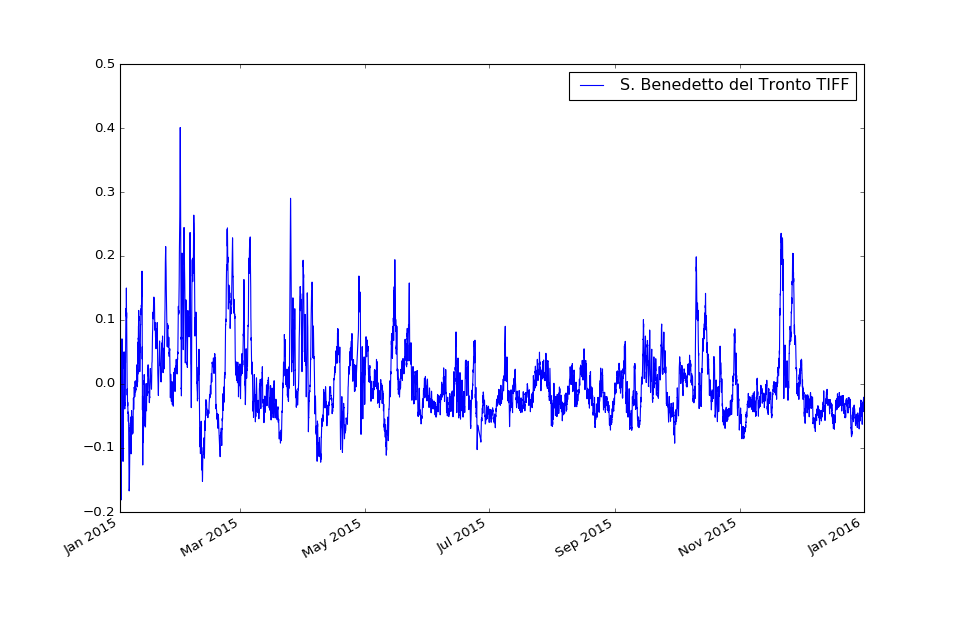

In [32]:
ax1 = resT.plot(figsize=(12,8))

<IPython.core.display.Javascript object>


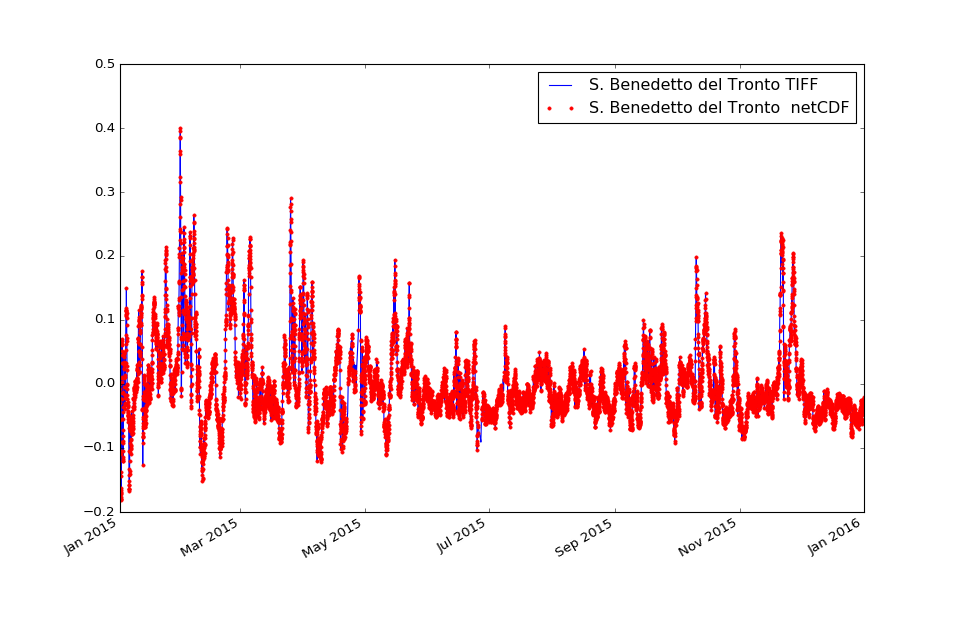

In [34]:
#plot both
ax1 = resT.plot(figsize=(12,8))
res.plot(ax=ax1,color='red', linestyle='', marker='.')